In [6]:
# install dependencies
!pip install -Uq sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


# Using Amazon SageMaker Debugger for PyTorch Training Jobs

Amazon SageMaker is a managed platform to build, train and host machine learning models. Amazon SageMaker Debugger is a new feature which offers capability to debug machine learning and deep learning models during training by identifying and detecting problems with the models in real time.

Amazon SageMaker also gives you the option of bringing your own algorithms packaged in a custom container, that can then be trained and deployed in the Amazon SageMaker environment. 

This notebook guides you through an example of using your own container with PyTorch for training, along with the recently added feature, Amazon SageMaker Debugger.

![debugger_overvew](images/debug_image_1.png)

----

## How does Amazon SageMaker Debugger work?

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in real time using rules and CloudWatch events and react to issues like, for example, common training issues such as vanishing gradients or poor weight initialization.

![debugger_overview](images/debug_image_2.png)

### Concepts

* **Output Tensor**: These are the artifacts that define the state of the training job at any particular instant in its lifecycle.
* **Debug Hook**: Captures the tensors flowing through the training computational graph every N steps.
* **Debugging Rule**: Logic to analyze the tensors captured by the hook and report anomalies.

With these concepts in mind, let's understand the overall flow of things which Amazon SageMaker Debugger uses to orchestrate debugging.

It operates in two steps - saving tensors and analysis.

![debugger_sysarch](images/debug_system_arch.png)

### Saving tensors

Tensors that debug hook captures are stored in S3 location specified by you. There are two ways you can configure Amazon SageMaker Debugger for storage:

   1. **Zero code change**: If you use any of SageMaker provided [Deep Learning containers](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) then you don't need to make any changes to your training script for tensors to be stored. Amazon SageMaker Debugger will use the configuration you provide in the framework `Estimator` to save tensors in the fashion you specify.
       
       **Note**: In case of PyTorch training, Debugger collects output tensors in GLOBAL mode by default. In other words, this option does not distinguish output tensors from different phases within an epoch, such as training phase and validation phase.
       
   2. **Script change**: Use the SageMaker Debugger client library, SMDebug, and customize training scripts to save the specific tensors you want at different frequencies and configurations. Refer to the [DeveloperGuide](https://github.com/awslabs/sagemaker-debugger/tree/master/docs) for details on how to use SageMaker Debugger with your choice of framework in your training script.
   
In this notebook, we choose the second option to properly save the output tensors from different training phases.

### Analysis of tensors

Once tensors are saved, Amazon SageMaker Debugger can be configured to run debugging ***Rules*** on them. On a very broad level, a rule is a python script used to detect certain conditions during training. Some of the conditions that a data scientist training an algorithm might be interested in are monitoring for gradients getting too large or too small, detecting overfitting, and so on. Amazon SageMaker Debugger comes pre-packaged with certain built-in rules. You can also write your own rules using the Amazon SageMaker Debugger APIs. You can also analyze raw tensor data outside the Rules construct in a notebook, using Amazon SageMaker Debugger's full set of APIs.

![debugger_sysarch](images/debug_builtin_rules_1.png)
### 
![debugger_sysarch](images/debug_builtin_rules_2.png)
### 
![debugger_sysarch](images/debug_builtin_rules_3.png)
### 


----

## Import SageMaker Python SDK and install required packages

In [7]:
import sagemaker

sagemaker.__version__

'2.70.0'

This notebook works with the SageMaker Python SDK version **2.39.1 or later**.

In [8]:
import pip
import sys

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        !{sys.executable} -m pip install {package}
        
required_packages=['smdebug', 'pytest']

for package in required_packages:
    import_or_install(package)

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


----

## Modify a PyTorch training script

We will focus on how to modify a training script to save tensors by registering debug hooks and specifying which tensors to save.

The model used for this notebook is trained with the MNIST dataset. The example is based on https://github.com/pytorch/examples/blob/master/mnist/main.py (the version as of October 2020).

### Modifying the training script

Before we define a PyTorch estimator and start training, we will explore parts of the training script in detail. (The entire training script can be found at [./scripts/pytorch_mnist.py](./scripts/pytorch_mnist.py)).

- **Step 1**: Import Amazon SageMaker Debugger client library, SMDebug.

    ```python
    import smdebug.pytorch as smd
    
    ```


- **Step 2**: In the `train()` function, add the SMDebug hook for PyTorch with `TRAIN` mode.

    ```python
    hook.set_mode(smd.modes.TRAIN)
    ```


- **Step 3**: In the `test()` function, add the SMDebug hook for PyTorch with `EVAL` mode.

    ```python
    hook.set_mode(smd.modes.EVAL)
    ```


- **Step 4**: In the `main()` function, create the SMDebug hook and register to the model.

    ```python
    hook = smd.Hook.create_from_json_file()
    hook.register_hook(model)
    ```


- **Step 4**: In the `main()` function, pass the SMDebug hook to the `train()` and `test()` functions in the epoch loop.

    ```python
    train(args, model, device, train_loader, optimizer, epoch, hook)
    test(model, device, test_loader, hook)
    ```

In [9]:
#!pygmentize ./scripts/pytorch_mnist.py

# The official PyTorch CNN model with MNIST training script
# https://github.com/pytorch/examples/blob/master/mnist/main.py

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# ====================================#
# 1. Import SMDebug framework class. #
# ====================================#
import smdebug.pytorch as smd


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
 

----

## Set up a PyTorch estimator and run a training job

Once these changes are made in the training script, Amazon SageMaker Debugger will start saving tensors during training into a specified output S3 bucket.

Now, we will set up the estimator and start training using the modified training script.

In [10]:
from __future__ import absolute_import

import boto3
import pytest
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
)

Define the configuration of training to run. `ecr_image` is where you can provide link to your bring-your-own-container. `hyperparameters` are fed into the training script with data directory (directory where the training dataset is stored) and smdebug directory (directory where the tensors will be saved) are mandatory fields.

In [11]:
hyperparameters = {"epochs": "5", "batch-size": "32", "test-batch-size": "100", "lr": "0.001"}

### Configure a Debugger rule object

The `rules` parameter is a new parameter that accepts a list of rules against output tensors that you want to evaluate.

In this example, we use the following Debugger rules that will attempt to evaluate if there are overfit, overtraining, and vanishing gradients problems.

In [12]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

For more information about the rules, see the following documentation.

- [Vanishing gradient](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#vanishing-gradient)
- [Overfit](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#overfit)
- [Overtraining](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#overtraining)
- [Poor weight initialization](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#poor-weight-initialization)

In addition to the model debugging rules above, SageMaker Debugger runs the ProfilerReport rule by default. This runs rules for system bottleneck detections and autogenerates a profiling report. For more information, see the following documentation:

- [SageMaker Debugger Profiling Report](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html)
- [ProfilerReport rule](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#profiler-report)

### Configure Debugger hook parameters

The following code shows how to adjust save intervals of the output tensors in the different training phases.

In [13]:
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

### Construct a PyTorch estimator with the Debugger parameters

In [14]:
estimator = PyTorch(
    entry_point="scripts/pytorch_mnist.py",
    base_job_name="smdebugger-demo-mnist-pytorch",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=400,
    max_run=3600,
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
)

### Start the training job

In [15]:
estimator.fit(wait=True)

2021-12-07 23:30:29 Starting - Starting the training job...
2021-12-07 23:30:30 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport-1638919828: InProgress
......
2021-12-07 23:31:59 Starting - Preparing the instances for training............
2021-12-07 23:33:53 Downloading - Downloading input data
2021-12-07 23:33:53 Training - Downloading the training image.................................
2021-12-07 23:39:29 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-07 23:39:30,633 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-07 23:39:30,657 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-07 23:39:30,667 sagemaker_pytorch_container.training

----

## Check SageMaker Debugger rule summaries

As a result of calling the `fit()` method, Amazon SageMaker Debugger starts a rule evaluation job to monitor `vanishing_gradient()`, `overfit()`, and `overtraining()` issues in parallel with the training job. 

The `ProfilerReport` rule runs for all SageMaker training jobs by default. You will be able to receive a comprehensive training report regarding system bottlenecks and framework profiling.

### Print the latest training job's rule summary in real time

In [16]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [17]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(100)

### Print URLs to the corresponding processing job logs in CloudWatch

In [18]:
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
    """Helper function to get the rule job name with correct casing"""
    return "{}-{}-{}".format(
        training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
    )


def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(
        region, region, rule_job_name
    )


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]

    result = {}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(
                training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"]
            )
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(
                rule_job_name, region
            )
    return result


get_rule_jobs_cw_urls(estimator)

{'VanishingGradient': 'https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-pyto-VanishingGradient-9a8f3fee;streamFilter=typeLogStreamPrefix',
 'Overfit': 'https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-pyto-Overfit-f5c8d1a5;streamFilter=typeLogStreamPrefix',
 'Overtraining': 'https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-pyto-Overtraining-62fa073c;streamFilter=typeLogStreamPrefix',
 'PoorWeightInitialization': 'https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-pyto-PoorWeightInitialization-ed568e4d;streamFilter=typeLogStreamPrefix'}

----

## SageMaker Debugger reports and analysis

Another aspect of the Amazon SageMaker Debugger is analysis. It allows us to perform interactive exploration of the tensors saved in real time or after the job. Here we focus on after-the-fact analysis of the above job. We import the smdebug library, which defines a concept of Trial that represents a single training run. Note how we fetch the path to debugger artifacts for the above job.

### Create an SMDebug trial object and retrieve saved output tensors

In [31]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-12-08 00:48:46.429 datascience-1-0-ml-g4dn-xlarge-efceabfff6e3400d69a4fdf20a35:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-328296961357/smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/debug-output


### Print check what output tensors are saved

We can list all the tensors that were recorded to know what we want to plot.

In [20]:
trial.tensor_names()

[2021-12-07 23:42:17.470 datascience-1-0-ml-g4dn-xlarge-efceabfff6e3400d69a4fdf20a35:20 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-07 23:42:18.489 datascience-1-0-ml-g4dn-xlarge-efceabfff6e3400d69a4fdf20a35:20 INFO trial.py:210] Loaded all steps


['gradient/Net_conv1.bias',
 'gradient/Net_conv1.weight',
 'gradient/Net_conv2.bias',
 'gradient/Net_conv2.weight',
 'gradient/Net_fc1.bias',
 'gradient/Net_fc1.weight',
 'gradient/Net_fc2.bias',
 'gradient/Net_fc2.weight',
 'nll_loss_output_0']

We can also retrieve tensors by some default collections that smdebug creates from your training job. Here we are interested in the losses collection, so we can retrieve the names of tensors in losses collection as follows. Amazon SageMaker Debugger creates default collections such as weights, gradients, biases, losses automatically. You can also create custom collections from your tensors.

### Check the number of steps saved in the different training phases

In [21]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.TRAIN))

94

In [22]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.EVAL))

50

### Set up functions to log and plot the output tensors

In [23]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


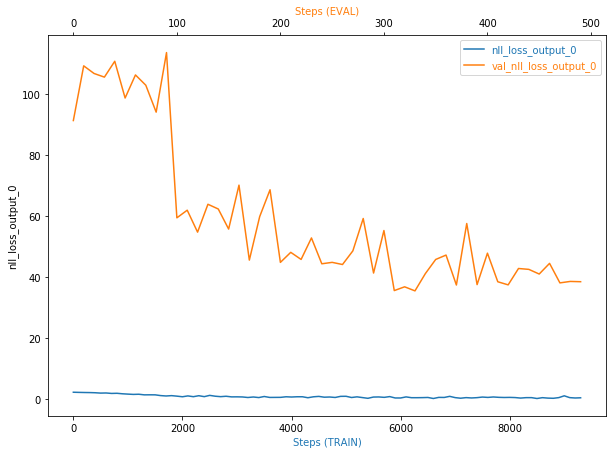

In [25]:
plot_tensor(trial, "nll_loss_output_0")

### Reflect the rule summary report

Recall what the rule summary reported:

```
Overfit :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule Overfit at step 4000 resulted in the condition being met
```

Based on this rule evaluation and the plot above, we can conclude that the training job has an overfit issue. While the `nll_loss_output_0` line is decreasing, the `val_nll_loss_output_0` line is fluctuating and not decreasing. 

To resolve the overfit problem, you need to consider using or double-checking the following techniques:

- Regularization
- Weight initialization
- Dropout regularization
- Weight constraints

### Download, open, and display the ProfilerReport HTML file

In [32]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [33]:
! aws s3 ls {rule_output_path} --recursive

2021-12-07 23:42:01     335946 smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-report.html
2021-12-07 23:42:00     178361 smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-report.ipynb
2021-12-07 23:41:56        191 smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-reports/BatchSize.json
2021-12-07 23:41:56      18923 smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-07 23:41:56        126 smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-reports/Dataloader.json
2021-12-07 23:41:56        129 smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-reports/GPUMe

In [28]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-west-2-328296961357/smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport-1638919828/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-west-2-328296961357/smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-reports/BatchSize.json to ProfilerReport-1638919828/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-2-328296961357/smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-report.ipynb to ProfilerReport-1638919828/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-west-2-328296961357/smdebugger-demo-mnist-pytorch-2021-12-07-23-30-28-258/rule-output/ProfilerReport-1638919828/profiler-output/profiler-reports/Dataloader.json to ProfilerReport-16

In [29]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [30]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")